# 流形学习

主成分分析对于非线性关系（相关系数）的数据集的处理效果并不太好   
流形学习的假设是：我们用来描述数据集的维度，通常是冗余的，我们所有的数据，其实仅仅是我们用到的高维度空间内的一个流形。   
通过特定的描述，可以在保留流形"平面" 特征的同时，又使得整体数据降维，利于后续的分析，同时原有流形还可以回归到原空间中   

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 数据生成

In [2]:
def make_hello(N = 1000, rseed = 42):
    # 画出 “Hello” 文字形状的图像，并保存成PNG
    fig, ax = plt.subplots(figsize = (4, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'Hello', va = 'center', ha = 'center', weight = 'bold', size = 85)
    plt.savefig('../data/hello.png')
    plt.close(fig)
    
    # 打开这个png并把一些随机点画上去
    from matplotlib.image import imread
    # 每个像素点是四维数据,取每个像素第一个点，并且把图像上下翻转后转置，可以用 plt.imshow 查看
    data = imread('../data/hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    # 随机取 4 * N 个点
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    # 4 * N个点中，选择非1的点
    mask = (data[i, j]< 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    # 取前1000个
    X = X[:N]
    return X[np.argsort(X[:, 0])]

(0.4962092113254688,
 3.5322107682468853,
 0.030019048107146985,
 0.99907763770618352)

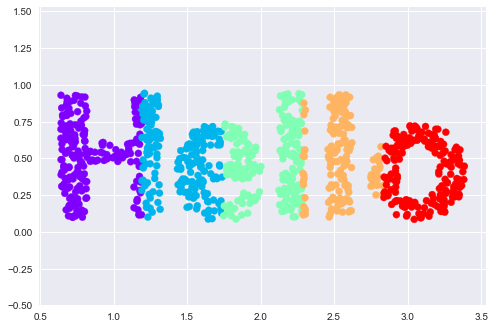

In [3]:
X = make_hello(1000, rseed=100)
colorsize = dict(c = X[:, 0], cmap = plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:,0], X[:, 1], **colorsize)
plt.axis('equal')

## 多维标度法（MDS）

可以看到数据集中选中的x和y值并不是对数据的最基本的描述：即使放大，缩小或者旋转数据，Hello仍然会很明显，数据的基本形状是一样的。   
说明x 和 y的值并不是数据间关系的必要基础特征，这个例子中真正的基础特征应该是每个点与数据集中其他点的距离

(5.1382855734429205, 8.212776988227068, 5.2561588427014998, 6.8424540110448948)

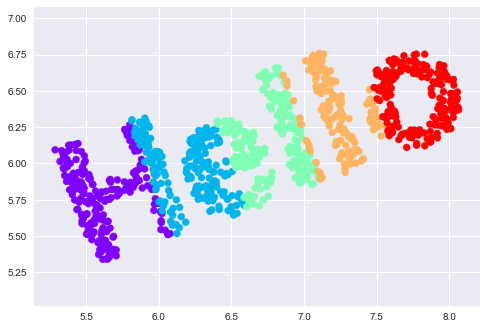

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorsize)
plt.axis('equal')

利用sklearn的 pairwise_distances 来计算关系矩阵

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

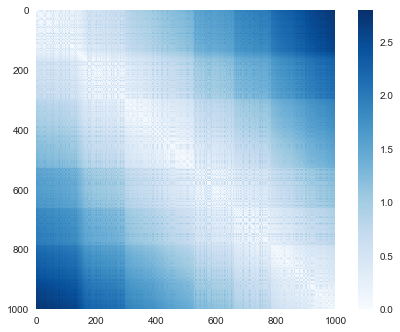

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation = 'nearest')
plt.colorbar()

如果用类似的方法为已经做过旋转和平移的数据构建一个距离矩阵，会看到同样的结果

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D,D2)

True

以上的关系矩阵，可以还原成原有形式

(-1.4182178334158551,
 1.4070638790638377,
 -1.1292827609701832,
 1.0299169717722709)

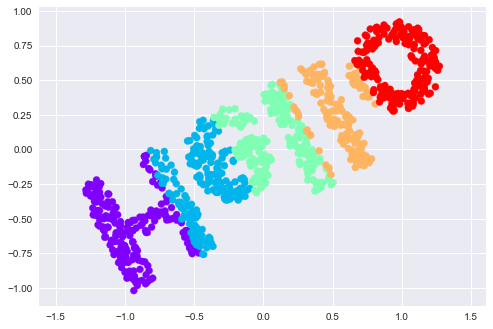

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 1)
out = model.fit_transform(D)
plt.scatter(out[:,0], out[:,1], **colorsize)
plt.axis('equal')

虽然形状有点不一样，但还原了    
同理，关系矩阵对于任何高维图形来说，都是一样的，Hello可以出现在三维甚至之上的空间中，但是距离矩阵是一样的。  
根据距离矩阵还原到二维，就等于是把数据降维了，信息还没有丢失

In [9]:
# 把数据扩展到3维
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

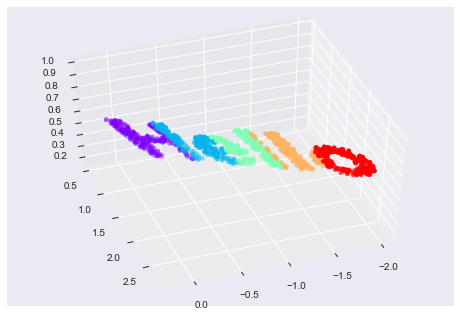

In [10]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection = '3d')
ax.scatter3D(X3[:,0],X3[:,1],X3[:,2],**colorsize)
ax.view_init(azim = 70, elev = 50)

(-1.4182178334158584,
 1.4070638790638399,
 -1.1292827609701839,
 1.0299169717722716)

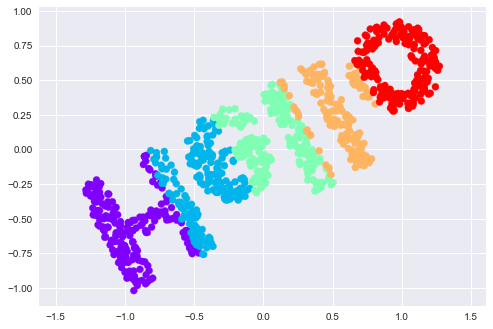

In [11]:
model = MDS(n_components = 2, random_state =1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:,0], out3[:,1], **colorsize)
plt.axis('equal')

MDS 保留的数据是没对数据点之间的距离

## 非线性嵌入：当MDS失败时

当低维数据在高维的数据嵌入是非线性的时候，用MDS就会失败，就好像求地球表面两点距离，穿越了地表的距离是没有意义的

In [12]:
# 将输入数据在三维空间中扭曲成“S”形状的示例

def make_hello_s_curve(X):
    t = (X[:, 0] - 2)*0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x,y,z)).T

XS = make_hello_s_curve(X)

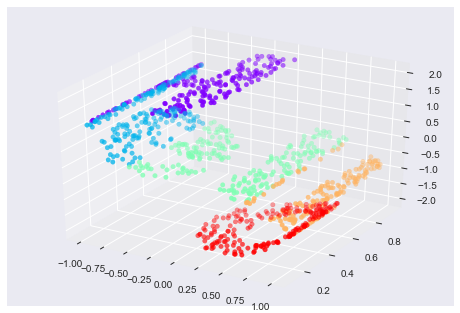

In [13]:
ax = plt.axes(projection = '3d')
ax.scatter3D(XS[:,0],XS[:,1],XS[:,2],**colorsize)

(-2.1193340042840907,
 2.013713728306521,
 -1.4670726003686712,
 1.4723010255816638)

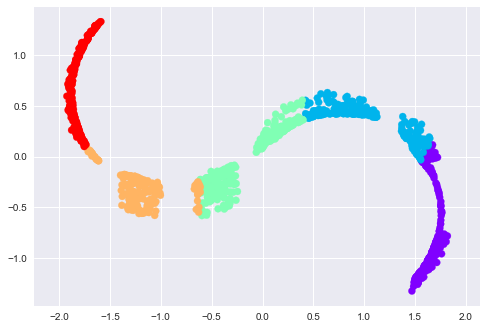

In [14]:
# 此时用MDS就会很尴尬
model = MDS(n_components = 2, random_state = 2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorsize)
plt.axis('equal')

## 非线性流型：局部线性嵌入

算法，让其只保留比较接近的点之间的距离，嵌入的结果可能会与我们的期望更接近

(0.15, -0.15)

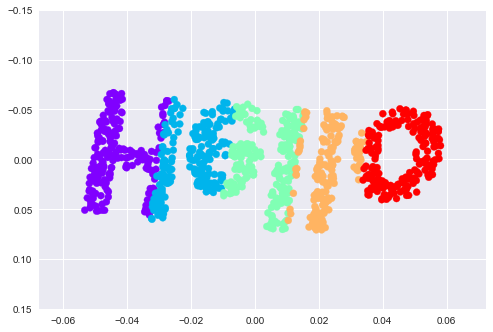

In [15]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors = 100, n_components = 2, method = 'modified',
                              eigen_solver = 'dense')
out = model.fit_transform(XS)

fig,ax = plt.subplots()
ax.scatter(out[:,0], out[:, 1], **colorsize)
ax.set_ylim(0.15,-0.15)

保留了一定的原始关系

## 一些思考
* 现实中很难找到使用场景
* 没有比较好的方法处理缺失值
* 对噪音的处理比较灾难
* 高度依赖所选取的邻接点的个数
* 全局最优的输出维度很难确定，PCA可以基于解释方差来确定输出的维度数
* 嵌入维度的含义并不是很清楚
* 速度相对PCA较慢

优点
* 保留非线性信息

## 示例： 用Isomap处理人脸数据

In [16]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

### 图形可视化

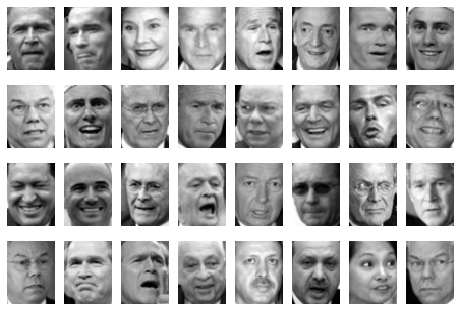

In [17]:
fig, ax = plt.subplots(4, 8, subplot_kw = dict(xticks = [], yticks = []))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap = 'gray')

我们希望把这 2914 的数据降维，以此来了解图像之间的基本关系，用PCA 可以可以判断需要多少线性特征才能描述数据

(0, 100)

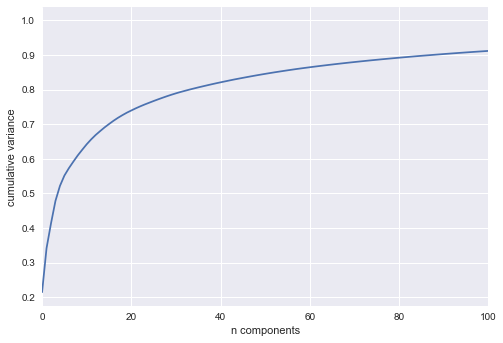

In [18]:
from sklearn.decomposition import PCA
model = PCA(svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.xlim([0,100])

可以看到，要100维的数据才能保存90%的方差，仅通过线性成分无法描述，因此引入非线性的流形嵌入方法

In [19]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

得到了两维的数据，这两维的数据存储着各个图从黑到白，视角的一些信息

In [20]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

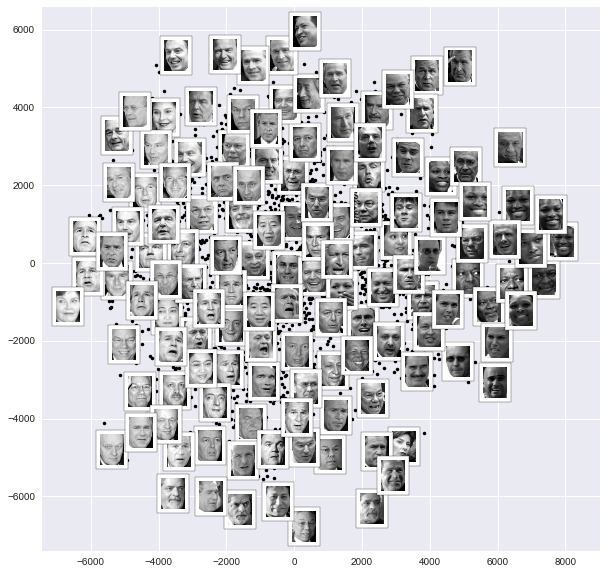

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

## 手写数字的可视化结构

In [22]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

数据展示

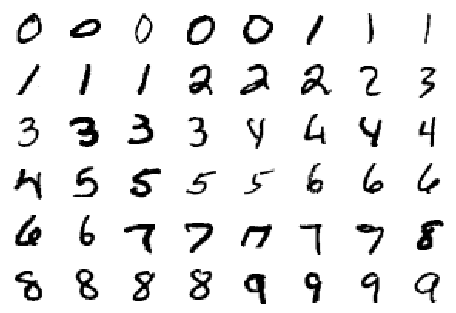

In [23]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

画出少量数据

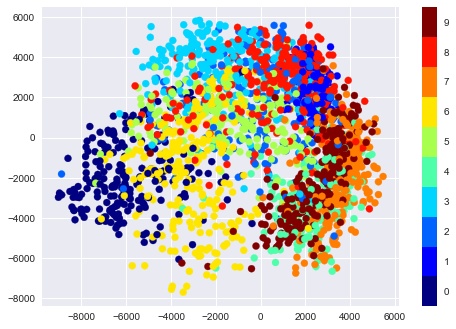

In [24]:
# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

看单个数据的分布

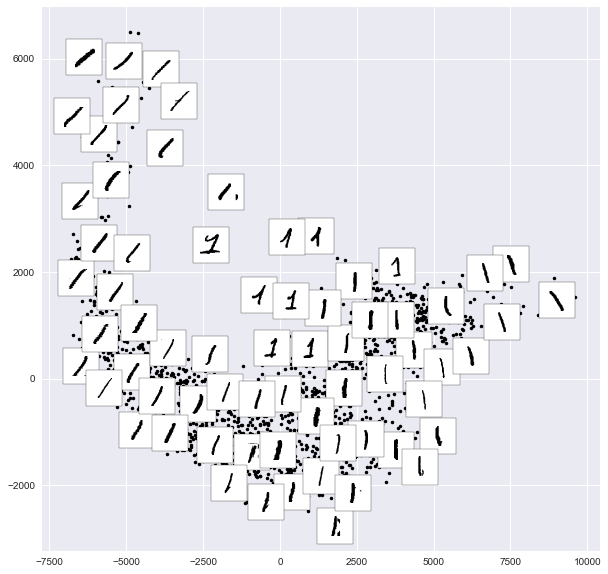

In [25]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

可能会对后续的分类有一定的启发